In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import PIL
import scipy
import skimage # 0.16 required

import utils

# create configparser to store config

In [2]:
import configparser
config = configparser.ConfigParser()

# Camera configuration

In [3]:
camera_config = {}

## List available cameras

In [4]:
import utils_camera

utils_camera.list_cameras()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


['/dev/video0']

<IPython.core.display.Javascript object>


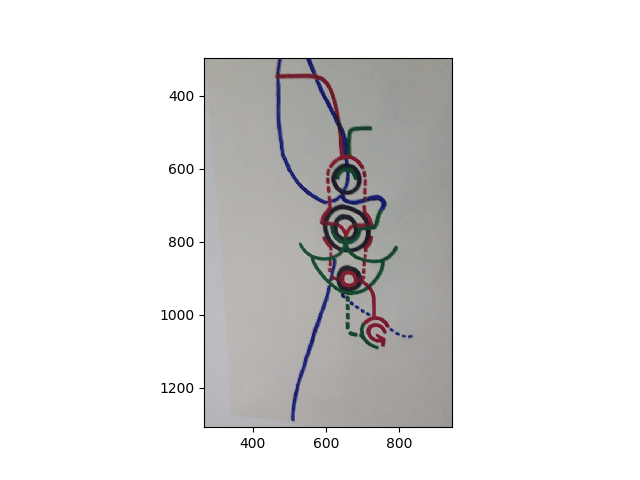

In [5]:
camera_url = '/dev/video0'
simulate = True
camera_config.update({'device_url': camera_url, 'simulate': simulate})
camera = utils_camera.get_camera(camera_url)
img = utils_camera.take_picture(camera, simulate=simulate)
camera.stop()
plt.figure()
plt.imshow(img);

# zoom to rectangle in figure above and get coordiantes

In [8]:
axis = plt.gca()
x_min, x_max, y_min, y_max = utils.get_axis_bounds(axis)
camera_config.update({'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max})

config['camera'] = camera_config

# Stroke configuration

## zoom to the right part of the image

<IPython.core.display.Javascript object>


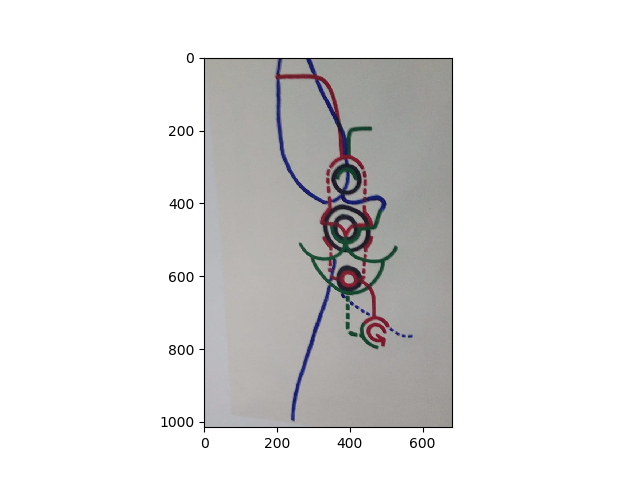

In [9]:
# NOTA: x asix it the second axis
img_np = img[y_min:y_max+1, x_min:x_max+1]
plt.figure()
plt.imshow(img_np);

# Define the colors and plot distance histograms

<IPython.core.display.Javascript object>


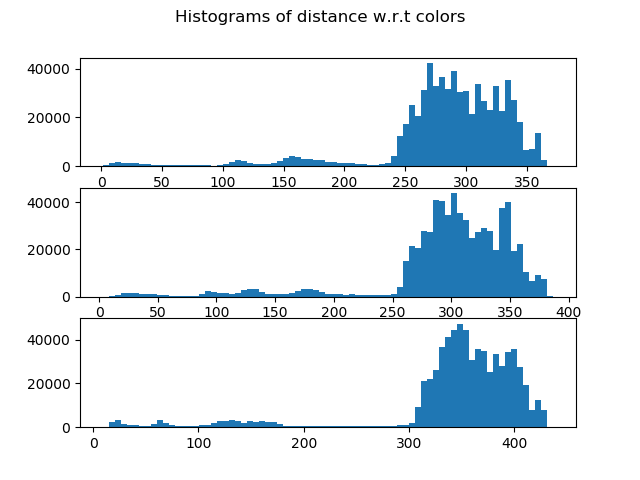

In [10]:
red = np.array([130, 25, 50]).reshape((1,1,3));
blue = np.array([30, 30, 130]).reshape((1,1,3));
green = np.array([20, 80, 40]).reshape((1,1,3));

config['strokes'] = {
    'red': str(red.reshape(-1).tolist()),
    'blue': str(blue.reshape(-1).tolist()),
    'green': str(green.reshape(-1).tolist())
}

colors = [red, blue, green]

utils.plot_color_distance_histograms(img_np, colors, bins=75)


# define appropriate distance thresholds to separate color

<IPython.core.display.Javascript object>


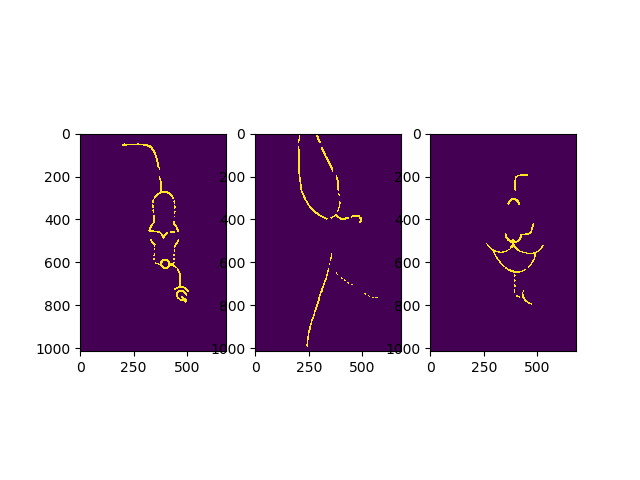

In [11]:
red_threshold = 75
blue_threshold = 80
green_threshold = 50
thresholds = [red_threshold, blue_threshold, green_threshold]

config['strokes'].update({'red_threshold': str(red_threshold), 'blue_threshold': str(blue_threshold), 'green_threshold': str(green_threshold)})            
red_img, blue_img, green_img = utils.separate_color_images(img_np, colors, thresholds)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_img)
ax2.imshow(blue_img)
ax3.imshow(green_img);

## get strokes

<IPython.core.display.Javascript object>


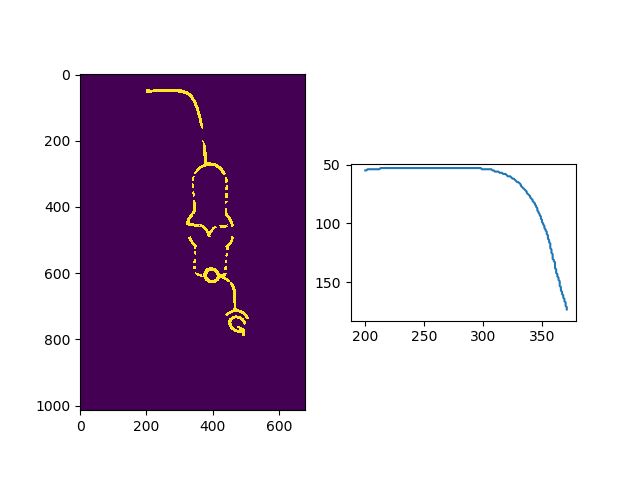

In [13]:
red_strokes = utils.get_strokes(red_img)


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(red_img)

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for stroke in red_strokes:
    stroke = np.array(stroke)
    ax2.plot(stroke[:,1], stroke[:,0])




# find the connected components of the color images and select one

<IPython.core.display.Javascript object>


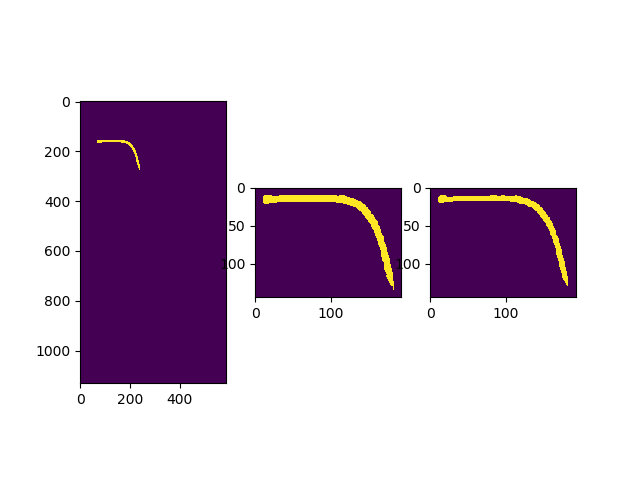

In [33]:
# for the red color
# i = 0, 6, 7, 8, 10, 12, 13, 17, 24  are ok
# i = 1, 22, 23 are problematic because the need several lines
# i = 2, 3, 4, 5 11, 14, 15, 16, 18, 19, 20, 21  have a single point
i = 0
red_component = utils.get_connected_components(red_img, i+1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_component)

red_component = utils.zoom_on_nonzero(red_component)
ax2.imshow(red_component)

red_component_smooth = scipy.ndimage.gaussian_filter(red_component, sigma=0.8) > 0.8
ax3.imshow(red_component_smooth);

#  Find the middle line of a component 

## Best method : find skeleton with skimage

<IPython.core.display.Javascript object>


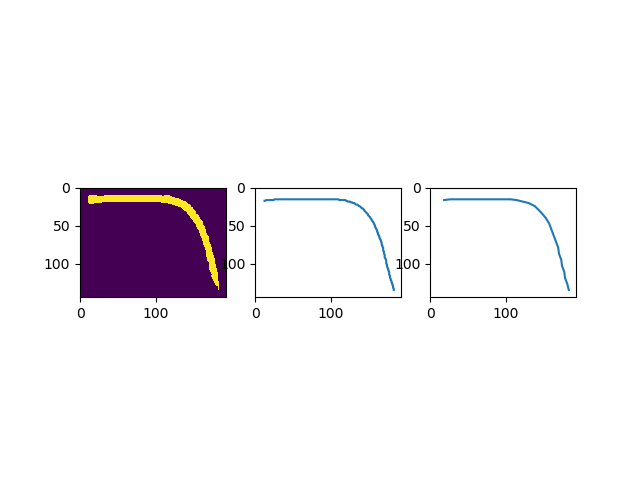

In [13]:
from skimage.morphology import skeletonize, medial_axis

skeleton = skeletonize(red_component)
strokes = utils.convert_mask_to_strokes(skeleton, red_component, max_dist=3)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(red_component);

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for stroke in strokes:
    stroke = np.array(stroke)
    ax2.plot(stroke[:,1], stroke[:,0])

subsample = 8
ax3.set_xlim(ax1.get_xlim());
ax3.set_ylim(ax1.get_ylim());
ax3.set_aspect(ax1.get_aspect());
for stroke in strokes:
    stroke = np.array(stroke)
    ax3.plot(stroke[::subsample,1], stroke[::subsample,0])
    
config['strokes']['skeleton_subsample'] = str(subsample)

## Method 1 : apply a gaussian blur and look for local maximas

<IPython.core.display.Javascript object>


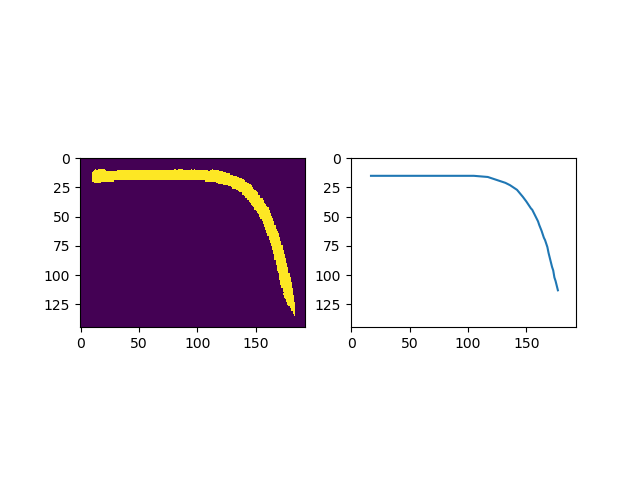

In [14]:

sigma_blur = 1.5 # try different values
middle_lines = utils.find_middle_lines_with_gaussian_blur(red_component, sigma_blur)



fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(red_component)

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for middle_line in middle_lines:
    stroke = np.array(middle_line)
    ax2.plot(stroke[:,1], stroke[:,0])


## Method 2 : apply succesive gaussian blurs and select isolated maximas

<IPython.core.display.Javascript object>


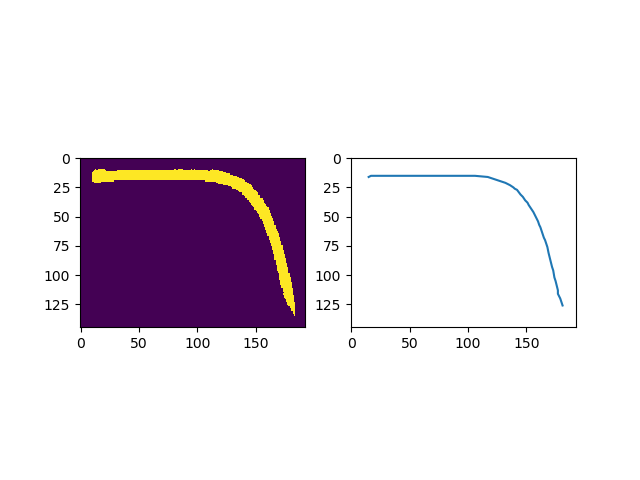

In [15]:



sigmas = [0.5, 0.6, 0.7, 0.8, 1., 1.2, 1.4, 1.8, 2]
middle_lines = utils.find_middle_lines_with_successive_gaussian_blurs(red_component, sigmas)


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(red_component)

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for middle_line in middle_lines:
    stroke = np.array(middle_line)
    ax2.plot(stroke[:,1], stroke[:,0])


# Method 3: use IPOL contour detector + stroke-width transform

## save img, run subprocess

In [16]:
import subprocess

pgm_filename = 'component.pgm'
skimage.io.imsave(pgm_filename, (red_component * 255).astype('uint8'));
sigma = 4.
txt_filename = 'component.txt'

subprocess.run(['./devernay', pgm_filename, '-s', str(sigma), '-t', txt_filename]);

lines = list(open(txt_filename))

contours = []
tangeants = []
normals = []
contour_x = []
contour_y = []

for line in lines:
    x, y = [float(z) for z in line.split()]
    if x == -1 and y == -1:
        contour = np.array([contour_x, contour_y]).transpose()
        tangeant, normal = np.zeros_like(contour), np.zeros_like(contour)
        tangeant[1:-1] = contour[2:] - contour[:-2]
        tangeant[0] = contour[1] - contour[0]
        tangeant[-1] = contour[-1] - contour[-2]
        # tangeant /= tangeant.norm(p=2, axis=1)
        normal[:,0] = -tangeant[:,1]
        normal[:,1] = tangeant[:,0]

        contours.append(contour)
        tangeants.append(tangeant)
        normals.append(normal)

        contour_x = []
        contour_y = []
    else:
        contour_x.append(x)
        contour_y.append(y)



## plot the result

<IPython.core.display.Javascript object>


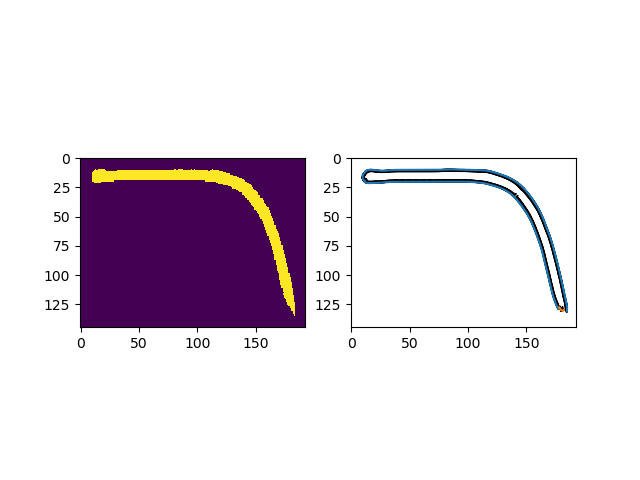

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(red_component)

for i in range(len(contours)):
    contour, tangeant, normal = contours[i], tangeants[i], normals[i]

    ax2.plot(contour[:,0], contour[:,1])
    for j in range(len(contour)):
        ax2.arrow(contour[j,0], contour[j,1],
                normal[j,0], normal[j,1], length_includes_head=True,  head_width=0.01*np.linalg.norm(normal[j], 2), head_length=0.1*np.linalg.norm(normal[j], 2))

    for j in range(len(contour)):
        ax2.arrow(contour[j,0], contour[j,1],
                tangeant[j,0], tangeant[j,1], length_includes_head=True,  head_width=0.01*np.linalg.norm(tangeant[j], 2), head_length=0.1*np.linalg.norm(tangeant[j], 2))
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_aspect(ax1.get_aspect())

## apply the stroke width transform

<IPython.core.display.Javascript object>


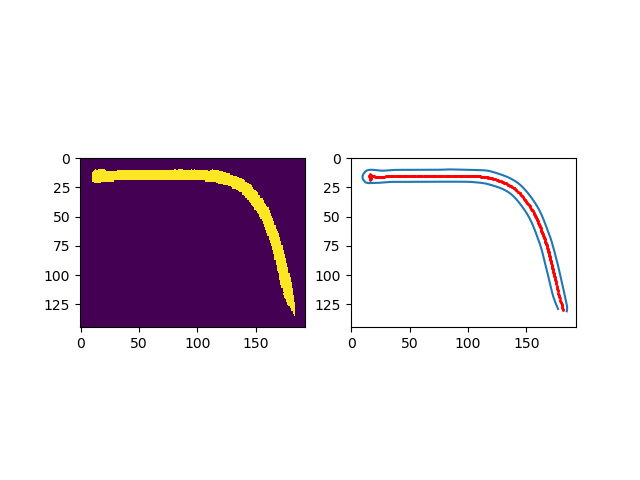

In [18]:
contour, normal = contours[0], normals[0]

contour_swt_image = np.zeros_like(contour)

max_stroke_width = 15.
dot_prod_thresh = 0.9

middle_line = []

for i in range(25, contour.shape[0]-1):
    point = contour[i]
    diff = contour - point
    # find the close points
    close_point_ids = np.argwhere(np.linalg.norm(diff, axis=1) < max_stroke_width).reshape(-1)
    
    if len(close_point_ids) > 0:
        close_points = contour[close_point_ids]
        close_points_diff = close_points - point
        close_point_diff_norm = close_points_diff / (np.linalg.norm(close_points_diff, axis=1) + 1e-7)[:, np.newaxis]
        normal_vector = normal[i] / np.linalg.norm(normal[i])
        dot_prod = (close_point_diff_norm * normal_vector).sum(axis=1)
        argmax =  np.argmax(dot_prod)
        if dot_prod[argmax] > dot_prod_thresh:
            img_point = contour[close_point_ids[argmax]]
            middle_line.append(0.5 * (point + img_point))
        
        
middle_line = np.array(middle_line)
    

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(red_component)
ax2.plot(contour[:,0], contour[:,1])
ax2.scatter(middle_line[:, 0], middle_line[:, 1], color='red', s=1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())    
ax2.set_aspect(ax1.get_aspect())

    

## Save the configfile

In [36]:
with open('config_example.ini', 'w') as configfile:
    config.write(configfile)